#### **This code accompanies the IEEE Access Journal: "Compact Model Parameter Extraction via Derivative-Free Optimization"**
**Paper link:** https://ieeexplore.ieee.org/abstract/document/10662920

*Written by Rafael Perez Martinez (Stanford University)*

Note: Before running this HEMT example, it is necessary to install NGSPICE, OpenVAF, and Optuna. This notebook is designed to be run in [Google Colab](https://colab.google/). It is recommended using a TPU for faster simulation time.

In [1]:
"""
MIT License

Copyright (c) 2024 Rafael Perez Martinez

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
""";

In [2]:
# NGSPICE Installation (can take up to 5-10 mins)
%%capture
!apt-get update
!apt-get install -y libxaw7-dev libxaw7
!wget http://sourceforge.net/projects/ngspice/files/ng-spice-rework/42/ngspice-42.tar.gz -O ngspice-42.tar.gz
!tar -zxvf ngspice-42.tar.gz
%cd ngspice-42
!./configure --enable-xspice --enable-osdi --disable-debug --with-readline=yes
!make clean
!make
!make install
!which ngspice
!ngspice --version

In [3]:
# OpenVAF installation
%%capture
!wget https://openva.fra1.cdn.digitaloceanspaces.com/openvaf_23_5_0_linux_amd64.tar.gz -O openvaf_23_5_0_linux_amd64.tar.gz
!tar -xvzf openvaf_23_5_0_linux_amd64.tar.gz
!ls
!chmod +x openvaf
!./openvaf --help

In [4]:
# Optuna installation
%%capture
!pip install optuna

In [5]:
# Download Verilog-A File
url = 'https://github.com/rafapm/dfo_parameter_extraction/blob/4793f34d5fbe8d02123581d90253d25260c23cf4/notebooks/HEMT_ex/asmhemt.va?raw=true'
!wget -O /content/asmhemt.va {url}
!./openvaf /content/asmhemt.va

--2024-10-08 17:19:20--  https://github.com/rafapm/dfo_parameter_extraction/blob/4793f34d5fbe8d02123581d90253d25260c23cf4/notebooks/HEMT_ex/asmhemt.va?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/rafapm/dfo_parameter_extraction/raw/4793f34d5fbe8d02123581d90253d25260c23cf4/notebooks/HEMT_ex/asmhemt.va [following]
--2024-10-08 17:19:21--  https://github.com/rafapm/dfo_parameter_extraction/raw/4793f34d5fbe8d02123581d90253d25260c23cf4/notebooks/HEMT_ex/asmhemt.va
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rafapm/dfo_parameter_extraction/4793f34d5fbe8d02123581d90253d25260c23cf4/notebooks/HEMT_ex/asmhemt.va [following]
--2024-10-08 17:19:21--  https://raw.githubusercontent.com/rafapm/dfo_parameter_extraction/4793f34d5fbe8d02123581d9025

In [6]:
# Download extract_model Python module
url_module = 'https://raw.githubusercontent.com/rafapm/dfo_parameter_extraction/refs/heads/main/notebooks/extract_model.py'
!wget -P /content/ {url_module}

--2024-10-08 17:19:39--  https://raw.githubusercontent.com/rafapm/dfo_parameter_extraction/refs/heads/main/notebooks/extract_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61501 (60K) [text/plain]
Saving to: ‘/content/extract_model.py’

extract_model.py    100%[===================>]  60.06K  --.-KB/s    in 0.009s  

2024-10-08 17:19:40 (6.36 MB/s) - ‘/content/extract_model.py’ saved [61501/61501]



#### This example corresponds to Section IV (150-nm GaN-on-SiC HEMT Fitting Example) of the manuscript.

#### We first do a test/train split, train the model, set the correct hyperparameters, and assess the model using test data

#### **Note:** In the paper, a step size of 0.1 V was used for both vd and vg, and in this notebook, a bigger step size was used to decrease simulation time. The original simulations of the paper were first done in Keysight IC-CAP.


In [7]:
import os
import numpy as np
import pandas as pd
import json

import importlib
import extract_model
importlib.reload(extract_model)
from extract_model import ExtractModel

In [8]:
# Instantiate the class
hemt = ExtractModel()

# Set inputs (voltage columns) and outputs (measured columns)
inputs = ['vd', 'vg']  # For transistor (two voltage inputs)
outputs = ['id', 'gm']  # For transistor (two measured outputs)
hemt.set_inputs_outputs(inputs=inputs, outputs=outputs)

# Set delta and epsilons for hyperparameters
delta=np.sqrt(0.15)
epsilons={'id': 1e-4, 'gm': 1e-3}
hemt.set_hyperparameters(delta, epsilons)

# Provide data url (from GitHub) and choose start, end, and step voltages
url = 'https://raw.githubusercontent.com/rafapm/dfo_parameter_extraction/main/notebooks/HEMT_ex/ngspice_notebook_and_files/id_gm_meas_data.csv'


# Voltages:  ['vd', 'vg']
start_vals = [0, -2.9]  # Start values for vd and vg
end_vals = [20, -0.1]  # End values for vd and vg
step_sizes = [0.4, 0.2]  # Step sizes for vd and vg

# Process data and do a train/test split
hemt.run_data_process(file_path=url, step_sizes=step_sizes, start_vals=start_vals, end_vals=end_vals)

# Now, the voltage sweeps and measured data are set up
print(f"vd: start={hemt.voltages_sweep['vd_start']}, stop={hemt.voltages_sweep['vd_stop']}, step={hemt.voltages_sweep['vd_step']}")
print(f"vg: start={hemt.voltages_sweep['vg_start']}, stop={hemt.voltages_sweep['vg_stop']}, step={hemt.voltages_sweep['vg_step']}")

vd: start=0.0, stop=20.0, step=0.4
vg: start=-2.9, stop=-0.1, step=0.2


In [9]:
# Define model parameter configuration for optimization
original_param_config = {
    "RTH0": {"min": 31.5, "max": 32.5, "scale": "lin"},
    "VOFF": {"min": -2.1, "max": -1.9, "scale": "lin"},
    "NFACTOR": {"min": 0.2, "max": 0.5, "scale": "lin"},
    "U0": {"min": 0.15, "max": 0.3, "scale": "lin"},
    "UA": {"min": 1e-8, "max": 50e-8, "scale": "lin"},
    "UB": {"min": 1e-21, "max": 1e-18, "scale": "log"},
    "VSAT": {"min": 150e3, "max": 250e3, "scale": "lin"},
    "LAMBDA": {"min": 100e-6, "max": 1500e-6, "scale": "lin"},
    "UTE": {"min": -1, "max": -0.1, "scale": "lin"},
    "ETA0": {"min": 10e-3, "max": 100e-3, "scale": "lin"},
    "VDSCALE": {"min": 2, "max": 6, "scale": "lin"},
    "CDSCD": {"min": 1e-3, "max": 150e-3, "scale": "lin"},
    "RSC": {"min": 100e-6, "max": 1500e-6, "scale": "lin"},
    "RDC": {"min": 100e-6, "max": 1500e-6, "scale": "lin"},
    "DELTA": {"min": 2, "max": 5, "scale": "lin"},
    "THESAT": {"min": 1, "max": 4, "scale": "lin"},
    "NJGD": {"min": 2.5, "max": 20, "scale": "lin"},
    "RNJGD": {"min": 15, "max": 30, "scale": "lin"},
    "IGDDIO": {"min": 7.5, "max": 15, "scale": "lin"},
    "RIGDDIO": {"min": 10e-9, "max": 100e-9, "scale": "lin"},
    "NJGS": {"min": 2.5, "max": 20, "scale": "lin"},
    "RNJGS": {"min": 5, "max": 15, "scale": "lin"},
    "IGSDIO": {"min": 2.5, "max": 10, "scale": "lin"},
    "RIGSDIO": {"min": 10e-9, "max": 100e-9, "scale": "lin"},
    "VSATACCS": {"min": 10e3, "max": 150e3, "scale": "lin"},
    "NS0ACCS": {"min": 5e15, "max": 5e20, "scale": "log"},
    "NS0ACCD": {"min": 5e15, "max": 5e20, "scale": "log"},
    "U0ACCS": {"min": 0.05, "max": 0.25, "scale": "lin"},
    "U0ACCD": {"min": 0.05, "max": 0.25, "scale": "lin"},
    "MEXPACCS": {"min": 1, "max": 5, "scale": "lin"},
    "MEXPACCD": {"min": 1, "max": 5, "scale": "lin"},
    "IMIN": {"min": 1e-15, "max": 1e-12, "scale": "log"},
    "GDSMIN": {"min": 1e-12, "max": 1e-6, "scale": "log"},
    "UTES": {"min": -17.5, "max": -5, "scale": "lin"},
    "UTED": {"min": -17.5, "max": -5, "scale": "lin"},
}

### **Note:** This method is probabilistic (i.e., you get a different result everytime you run it)
### You can make it deterministic by changing the sampler_behavior to 1 and adding a seed value

[I 2024-10-08 17:19:44,619] A new study created in memory with name: no-name-a90bfff1-f97f-4fc4-8333-189ca435a8fd
[I 2024-10-08 17:19:44,955] Trial 0 finished with value: 0.131085075588335 and parameters: {'RTH0': 31.91343656216438, 'VOFF': -2.0829879669462716, 'NFACTOR': 0.3092615516250449, 'U0': 0.2947295003371576, 'UA': 3.746269964784584e-07, 'UB': 1.5983812268054319e-21, 'VSAT': 235663.097828786, 'LAMBDA': 0.0011518828361232638, 'UTE': -0.905722509370344, 'ETA0': 0.05064145859306529, 'VDSCALE': 4.362054223948817, 'CDSCD': 0.08064827154433847, 'RSC': 0.0009025534705889072, 'RDC': 0.0008953342539599685, 'DELTA': 4.995664418428711, 'THESAT': 3.951478105355255, 'NJGD': 12.711715177554316, 'RNJGD': 29.11898047783437, 'IGDDIO': 12.365695647499033, 'RIGDDIO': 3.2371831028471176e-08, 'NJGS': 15.03627285556379, 'RNJGS': 13.339198829656002, 'IGSDIO': 9.182805176596057, 'RIGSDIO': 8.011205171046353e-08, 'VSATACCS': 91674.85535926446, 'NS0ACCS': 7884264801580088.0, 'NS0ACCD': 1.828072282679634

Best parameters saved to /content/best_parameters_train_test_split.json
Results saved to /content/study_results.csv
Simulation data saved to: /content/sim_clipped_all_data.csv
Reshape dimensions based on inputs ['vd', 'vg']: (51, 15)


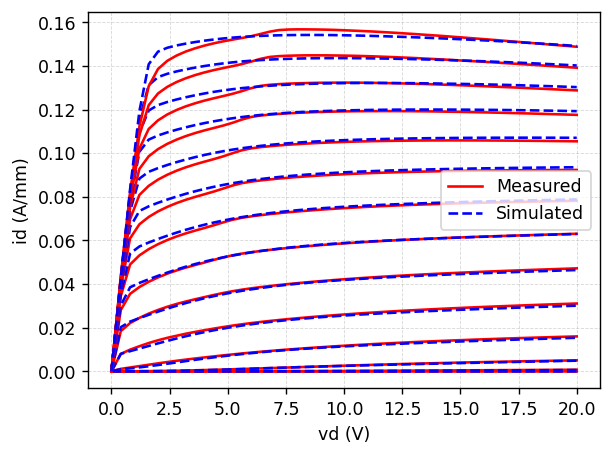

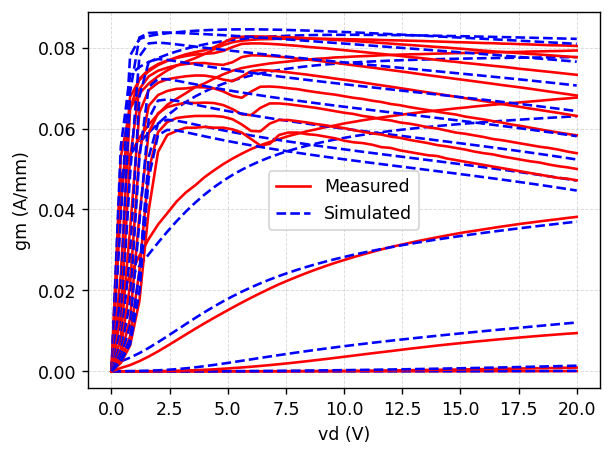

In [10]:
# Run optimization
hemt.run_optuna_optimization(
    num_trials=4250,  # Provide number of trials
    sampler_behavior=1, # 0 for probabilistic and 1 for deterministic
    seed_value=8040, # If deterministic, define the seed value here
    best_params_filename="best_parameters_train_test_split.json",
    results_filename="study_results.csv",
    param_config=original_param_config,
    use_all_data=False # If using train/test dataset, choose False
)
)

# Load the best parameters from the JSON file
best_params_train_test_split="best_parameters_train_test_split.json"

with open(f'/content/{best_params_train_test_split}', 'r') as f:
    best_params = json.load(f)

# Simulate and evaluate using the best parameters
results = hemt.simulate_and_evaluate(**best_params)

# Plot the simulation results
hemt.plot_simulation_results()

### Retrain (with fewer trials) using all data and with tighter parameter ranges

[I 2024-10-08 18:29:46,689] A new study created in memory with name: no-name-2354c2a2-5a8c-44a6-9f5c-a41bb72703b2
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[I 2024-10-08 18:29:46,818] Trial 0 finished with value: 0.007608694469102884 and parameters: {'RTH0': 31.571368344737703, 'VOFF': -1.981806628573323, 'NFACTOR': 0.46590818936160444, 'U0': 0.18562944983463764, 'UA': 1.8218295310247492e-08, 'UB': 2.8507185097627693e-21, 'VSAT': 160594.59590412208, 'LAMBDA': 0.0007711612102717722, 'UTE': -0.48546006074563214, 'ETA0': 0.048737153490289405, 'VDSCALE': 5.459731353815518, 'CDSCD': 0.03901557217658823, 'RSC': 0.00022306616221540385, 'RDC': 0.0012402076034914182, 'DELTA': 3.087015304478935, 'THESAT': 3.97822864705

Using all available data for optimization.
Enqueued initial parameters from /content/best_parameters_train_test_split.json


[I 2024-10-08 18:29:46,893] Trial 1 finished with value: 0.052411886556454096 and parameters: {'RTH0': 32.11217017561762, 'VOFF': -2.112974579459966, 'NFACTOR': 0.45449975875801224, 'U0': 0.19562605876175396, 'UA': 1.747253050086281e-08, 'UB': 2.6436041379498975e-21, 'VSAT': 150599.13850982423, 'LAMBDA': 0.0007588572548527105, 'UTE': -0.5108319374625159, 'ETA0': 0.04715471847146661, 'VDSCALE': 5.989911491034288, 'CDSCD': 0.03696902168301355, 'RSC': 0.00020438181298263226, 'RDC': 0.0012822755044969037, 'DELTA': 3.161871054028867, 'THESAT': 3.6954809777940145, 'NJGD': 14.884290217816387, 'RNJGD': 22.884404928924486, 'IGDDIO': 12.034958250720644, 'RIGDDIO': 4.639380258560548e-08, 'NJGS': 9.833498033058047, 'RNJGS': 13.132680711879141, 'IGSDIO': 7.342178619688973, 'RIGSDIO': 1.6161317913808065e-08, 'VSATACCS': 19482.47601983571, 'NS0ACCS': 6.7001405561075016e+19, 'NS0ACCD': 5.4587450758957e+19, 'U0ACCS': 0.07857847047698713, 'U0ACCD': 0.18074776927536307, 'MEXPACCS': 4.017627143000276, 'ME

Best parameters saved to /content/best_parameters_all_data.json
Results saved to /content/study_results_all_data.csv
Simulation data saved to: /content/sim_clipped_all_data.csv
Reshape dimensions based on inputs ['vd', 'vg']: (51, 15)


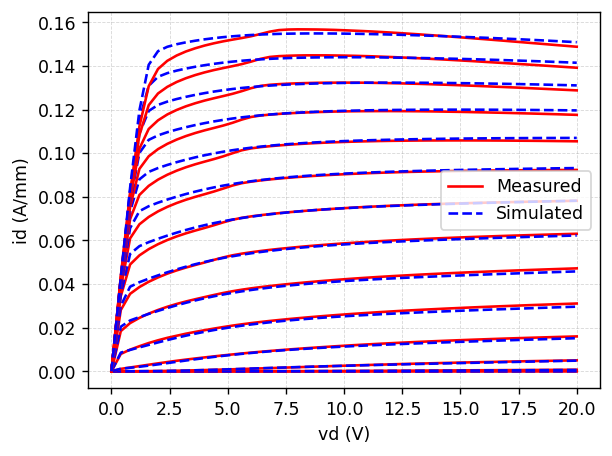

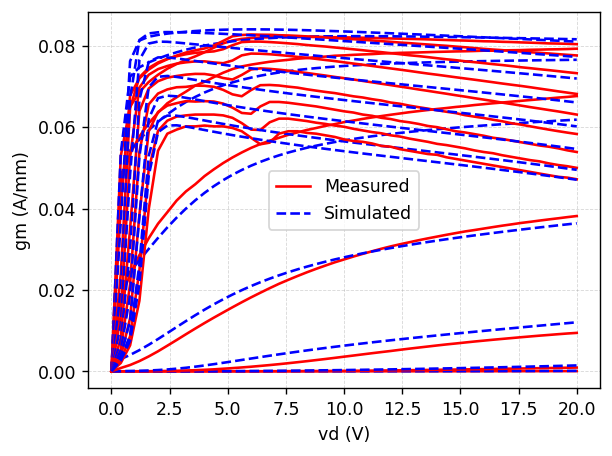

In [11]:
# Generate new param_config based on percentage_window to tighten parameter ranges
initial_params_file=f'/content/{best_params_train_test_split}'
percentage_window=0.1
best_params = hemt.load_parameters_from_json(initial_params_file)
param_config_new = hemt.generate_param_config_from_best_params(original_param_config=original_param_config, best_params=best_params, percentage=percentage_window)
best_parameters_all_data="best_parameters_all_data.json"

# Run optimization
hemt.run_optuna_optimization(
    num_trials=1500,  # Provide number of trials
    sampler_behavior=1, # 0 for probabilistic and 1 for deterministic
    seed_value=111, # If deterministic, define the seed value here
    best_params_filename="best_parameters_all_data.json",
    results_filename="study_results_all_data.csv",
    param_config=param_config_new,
    use_all_data=True, # If using all data, choose True
    initial_params_file=initial_params_file
)

# Load the best parameters from the JSON file
with open(f'/content/{best_parameters_all_data}', 'r') as f:
    best_params = json.load(f)

# Simulate and evaluate using the best parameters
results = hemt.simulate_and_evaluate(**best_params)

# Plot the simulation results
hemt.plot_simulation_results()